## File Outline

[1. Data Cleaning and Storage](#4.-Data-Cleaning-and-Storage)

[2. Vectorizers](#2.-Vectorizers)

[3. Principal Component Analysis](#4.-Principal-Component-Analysis)

[4. Base Models](#4.-Base-Models)

[5. Hyperparameter Tuning](#5.-Hyperparameter-Tuning)

[6. Model Performance](#6.-Model-Performance)

[7. KFold Cross-Validation](#7.KFold-Cross-Validation)

[8. Visualizations](#8.-Visualizations)

[9. Demo](#8.-Demo)

[10. Pickle Model](#8.-Pickle-Model)

## 1. Data Cleaning and Storage

### Import Libraries

In [30]:
import pdfplumber
import gensim
from gensim.parsing.preprocessing import remove_stopwords, STOPWORDS
import re
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from datetime import timedelta
from os import error
from os import listdir
from os.path import isfile, join
import json
import pandas as pd
import numpy as np
import requests
from pymongo import MongoClient

### Import Classes

In [31]:
from StockPuller import StockPuller
from PerformanceTester import PerformanceTester
from Database import Database

In [36]:
class Transcripts:
    def __init__(self, ticker):
    """ Identify path to folder where defined ticker's transcripts are stored on computer """
        self.ticker = ticker
        xinyu = "/Users/xinyuwu/Desktop/fall21/ds3500/DS3500-Final-Project"
        marco = "C:/Users/mtort/Repositories/DS3500-Final-Project"
        emily = "/Users/emilywang/Desktop/DS3500-Final-Project-main-2"
        kelly = "/Users/kelly/Desktop/ds3500/DS3500-Final-Project"
        qi = "/Users/liqi/Desktop/DS3500/DS3500-Final-Project-main-2"
        self.path = xinyu + "/transcripts/"+ticker+"_transcripts/"

    def read_files(self):
    """ Read all transcript files from folder """
        return [f for f in listdir(self.path) if isfile(join(self.path, f))]

    def create_dct(self):
    """ Make dictionary of transcripts and stock prie change data, return as a list of dictionaries for each transcript file in folder """
        lst_files = self.read_files()
        lst_cleaned = []
        
        # read in each file from folder
        for file in lst_files:
            file_path = self.path + file
            if file_path[-3:] == 'pdf':
                # clean text from transcript pdf
                txt = PdfCleaner(file_path) 
                date = file[:8]
                txt_cleaned = txt.clean_nums()
                
                # get stock price change data for given ticker and date
                PerfTest = PerformanceTester()
                PerfTest.setTimeframe('day', 1)
                PerfTest.loadArticles([[self.ticker, date, txt_cleaned]])
                try:
                    classification_xy = PerfTest.aquireTargetValues()
                except KeyError:
                    print(f'''Warning: attempted to access market during weekend or after hours
                          Earnings Transcript {file_path} Not Added
                          ''')
                    continue
                    
                # create dictionary for given transcript and add to list of dictionaries
                dct_cleaned = {'price_change': classification_xy[1][0], 'name': self.ticker, 'date': date, 'transcript': txt_cleaned}
                lst_cleaned.append(dct_cleaned)
        
        return lst_cleaned
    
class Database:
    def __init__(self):
    """ Establish mongoclient connection and create transcript database"""
        client = MongoClient()
        client.drop_database('transcripts')
        self.db = client.transcripts

    def store_data(self, tickers_lst):
    """ Store transcript data for each ticker into mongodb database"""
        for t in tickers_lst:
            store = Transcripts(t)
            transcript = store.create_dct()
            self.db.transcript.insert_many(transcript)
            print(t + " transcripts stored successfully")
        return self.db

### Import Transcripts for 40 Largest NASDAQ and S&P500 Companies by Market Cap

To prevent "IOPub data rate exceeded error", enter into terminal: 
jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10

In [37]:
# list of 40 companies used to train the model
tickers = ['AAPL', 'ADBE', 'AMAT', 'AMD', 'AMGN', 'AMZN', 'ASML', 'AVGO', 'BAC', 'CHTR', 
           'CMCSA', 'COST',  'CSCO', 'FB', 'GOOGL', 'HD', 'HON', 'INTC', 'INTU', 'ISRG',
           'JD', 'JNJ', 'JPM', 'MA', 'MRNA', 'MSFT', 'NFLX', 'NVDA', 'PDD', 'PEP', 'PFE', 
           'PG', 'PYPL', 'QCOM', 'TMUS', 'TSLA', 'TXN', 'UNH', 'V', 'WMT']

# create database and add in data from tickers
database = Database()
db = database.store_data(tickers)

                          Earnings Transcript /Users/xinyuwu/Desktop/fall21/ds3500/DS3500-Final-Project/transcripts/AAPL_transcripts/20161025_Apple_Inc-_Earnings_Call_2016-10-25_FS000000002309526178.pdf Not Added
                          
                          Earnings Transcript /Users/xinyuwu/Desktop/fall21/ds3500/DS3500-Final-Project/transcripts/AAPL_transcripts/20161025_Apple_Inc-_Earnings_Call_2016-10-25_FS000000002309526172.pdf Not Added
                          
AAPL transcripts stored successfully
ADBE transcripts stored successfully
AMAT transcripts stored successfully
AMD transcripts stored successfully
AMGN transcripts stored successfully
                          Earnings Transcript /Users/xinyuwu/Desktop/fall21/ds3500/DS3500-Final-Project/transcripts/AMZN_transcripts/20190426_Amazon.com_Inc-_Earnings_Call_2019-4-25_DN000000002663104261.pdf Not Added
                          
AMZN transcripts stored successfully
ASML transcripts stored successfully
AVGO transcripts s

                          Earnings Transcript /Users/xinyuwu/Desktop/fall21/ds3500/DS3500-Final-Project/transcripts/COST_transcripts/20170303_COSTCO_WHOLESALE-_Earnings_Call_2017-3-2_FS000000002333920108.pdf Not Added
                          
                          Earnings Transcript /Users/xinyuwu/Desktop/fall21/ds3500/DS3500-Final-Project/transcripts/COST_transcripts/20170303_COSTCO_WHOLESALE-_Earnings_Call_2017-3-2_FS000000002333920096.pdf Not Added
                          
COST transcripts stored successfully
CSCO transcripts stored successfully
FB transcripts stored successfully
GOOGL transcripts stored successfully
HD transcripts stored successfully
                          Earnings Transcript /Users/xinyuwu/Desktop/fall21/ds3500/DS3500-Final-Project/transcripts/HON_transcripts/20210723_HONEYWELL_INTL-_Earnings_Call_2021-7-23_DN000000002960976620.pdf Not Added
                          
                          Earnings Transcript /Users/xinyuwu/Desktop/fall21/ds3500/DS

                          Earnings Transcript /Users/xinyuwu/Desktop/fall21/ds3500/DS3500-Final-Project/transcripts/HON_transcripts/20171020_HONEYWELL_INTL-_Earnings_Call_2017-10-20_FS000000002377203123.pdf Not Added
                          
                          Earnings Transcript /Users/xinyuwu/Desktop/fall21/ds3500/DS3500-Final-Project/transcripts/HON_transcripts/20170421_HONEYWELL_INTL-_Earnings_Call_2017-4-21_FS000000002343590290.pdf Not Added
                          
                          Earnings Transcript /Users/xinyuwu/Desktop/fall21/ds3500/DS3500-Final-Project/transcripts/HON_transcripts/20170721_HONEYWELL_INTL-_Earnings_Call_2017-7-21_FS000000002361204370.pdf Not Added
                          
                          Earnings Transcript /Users/xinyuwu/Desktop/fall21/ds3500/DS3500-Final-Project/transcripts/HON_transcripts/20170721_HONEYWELL_INTL-_Earnings_Call_2017-7-21_FS000000002361204364.pdf Not Added
                          
HON transcripts stored succ

NFLX transcripts stored successfully
NVDA transcripts stored successfully
                          Earnings Transcript /Users/xinyuwu/Desktop/fall21/ds3500/DS3500-Final-Project/transcripts/PDD_transcripts/20200522_Pinduoduo_Inc-_Earnings_Call_2020-5-22_DN000000002842636277.pdf Not Added
                          
                          Earnings Transcript /Users/xinyuwu/Desktop/fall21/ds3500/DS3500-Final-Project/transcripts/PDD_transcripts/20200821_Pinduoduo_Inc-_Earnings_Call_2020-8-21_DN000000002890027659.pdf Not Added
                          
                          Earnings Transcript /Users/xinyuwu/Desktop/fall21/ds3500/DS3500-Final-Project/transcripts/PDD_transcripts/20211126_Pinduoduo_Inc-_Earnings_Call_2021-11-26_RT000000002968946789.pdf Not Added
                          
                          Earnings Transcript /Users/xinyuwu/Desktop/fall21/ds3500/DS3500-Final-Project/transcripts/PDD_transcripts/20180831_Pinduoduo_Inc-_Earnings_Call_2018-8-30_FS00000000246323201

## 2. Vectorizers

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [39]:
def query_data():
    ''' Function to query for all transcripts and store as list '''
    all_companies = db.transcript.find()

    data = {}
    text = []

    for transcript in all_companies:
        data[transcript["name"]+" "+transcript["date"]] = transcript["transcript"]
        text.append(transcript["transcript"])
    
    return data, text

def tfidf(text):
    ''' Tfidf vectorizer to match words to TFIDF values '''
    vect = TfidfVectorizer(min_df=3, ngram_range = (1, 1)).fit(text)
    bag_of_words = vect.transform(text)
    feature_names = vect.get_feature_names()

    tfidf_df = pd.DataFrame(bag_of_words.toarray(), columns = feature_names)
    display(tfidf_df)
    return tfidf_df, bag_of_words

In [40]:
data, text = query_data()
tfidf_df, bag_of_words = tfidf(text)

aa  aaa  aacr  aaos      aapl  aaron  aarp   ab  abandon  abandoned  \
0     0.0  0.0   0.0   0.0  0.196585    0.0   0.0  0.0      0.0        0.0   
1     0.0  0.0   0.0   0.0  0.179662    0.0   0.0  0.0      0.0        0.0   
2     0.0  0.0   0.0   0.0  0.119412    0.0   0.0  0.0      0.0        0.0   
3     0.0  0.0   0.0   0.0  0.118783    0.0   0.0  0.0      0.0        0.0   
4     0.0  0.0   0.0   0.0  0.200302    0.0   0.0  0.0      0.0        0.0   
...   ...  ...   ...   ...       ...    ...   ...  ...      ...        ...   
1029  0.0  0.0   0.0   0.0  0.000000    0.0   0.0  0.0      0.0        0.0   
1030  0.0  0.0   0.0   0.0  0.000000    0.0   0.0  0.0      0.0        0.0   
1031  0.0  0.0   0.0   0.0  0.000000    0.0   0.0  0.0      0.0        0.0   
1032  0.0  0.0   0.0   0.0  0.000000    0.0   0.0  0.0      0.0        0.0   
1033  0.0  0.0   0.0   0.0  0.000000    0.0   0.0  0.0      0.0        0.0   

      ...  ﬂuctuations      ﬂuid  ﬂuidity  ﬂush  ﬂushed  ﬂux   ﬂy  ﬂyer  \
0     ...     0.000000  0.000000      0.0   0.0     0.0  0.0  0.0   0.0   
1     ...     0.007140  0.008559      0.0   0.0     0.0  0.0  0.0   0.0   
2     ...     0.000000  0.000000      0.0   0.0     0.0  0.0  0.0   0.0   
3     ...     0.000000  0.000000      0.0   0.0     0.0  0.0  0.0   0.0   
4     ...     0.000000  0.000000      0.0   0.0     0.0  0.0  0.0   0.0   
...   ...          ...       ...      ...   ...     ...  ...  ...   ...   
1029  ...     0.011856  0.000000      0.0   0.0     0.0  0.0  0.0   0.0   
1030  ...     0.000000  0.000000      0.0   0.0     0.0  0.0  0.0   0.0   
1031  ...     0.000000  0.000000      0.0   0.0     0.0  0.0  0.0   0.0   
1032  ...     0.000000  0.000000      0.0   0.0     0.0  0.0  0.0   0.0   
1033  ...     0.000000  0.000000      0.0   0.0     0.0  0.0  0.0   0.0   

      ﬂying  ﬂywheel  
0       0.0      0.0  
1       0.0      0.0  
2       0.0      0.0  
3       0.0      0.0  
4       0.0      0.0  
...     ...      ...  
1029    0.0      0.0  
1030    0.0      0.0  
1031    0.0      0.0  
1032    0.0      0.0  
1033    0.0      0.0  

[1034 rows x 21544 columns]

## 3. Principal Component Analysis

In [43]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [44]:
def pca(bag_of_words, n_components):
    ''' PCA to reduce total number of features before feeding into ML model '''
    # instantiate the PCA object and request reduced number of components (reduces number of columns/features)
    pca = PCA(n_components=n_components, random_state=3000)

    # standardize the features so they are all on the same scale
    features_standardized = StandardScaler().fit_transform(bag_of_words.toarray())

    # transform the standardized features using the PCA algorithm 
    reduced_data = pca.fit_transform(features_standardized)

    # show transformed results in dataframe
    pca_df = pd.DataFrame(reduced_data)#, columns = components)

    ''' Obtain target values (whether stock price increased, decreased, or stayed the same) 
    from database '''
    price_changes = []
    all_transcripts = db.transcript.find()
    for transcript in all_transcripts:
        price_changes.append(transcript['price_change'])

    pca_df['target'] = price_changes 

    return pca_df

In [61]:
pca_df = pca(bag_of_words, 400)
pca_df

0          1         2          3          4         5         6  \
0    -8.320075   9.447556 -6.215546   8.007536  -2.998994 -6.775484  0.200354   
1    -7.112281   5.083771 -5.368377   7.044893  -3.004844 -7.827979  1.047677   
2    -5.668454   9.982250  2.711897   2.705997   2.443702 -9.474586  2.359215   
3    -5.495510   8.267204  5.679843  -2.383181   4.274872 -6.107718  1.878540   
4    -7.164536   2.472796 -4.629903   6.223862  -3.951743 -5.203835  0.222572   
...        ...        ...       ...        ...        ...       ...       ...   
1029 -3.514407 -10.472821 -1.055074   6.529706   0.899277 -6.377775  5.515197   
1030 -3.645257   2.292870  8.313712  -4.034559   6.465782 -7.793555  5.971703   
1031 -5.728774  -4.081830  2.516463  -7.650001   5.765125 -5.231971  5.531820   
1032 -5.315560 -12.632022 -3.313562  -0.593065   3.035647 -4.200671  2.033839   
1033 -6.019994  -0.094561  9.066583 -11.748588  10.658633 -8.754391  7.417004   

              7         8          9  ...       391       392        393  \
0     -6.209848  2.378530  -3.300350  ...  2.140400  1.150500   1.379651   
1     -6.850538 -0.648962  -4.084993  ...  5.646788 -5.588715  -1.515992   
2     -2.329498 -3.354164   6.789855  ... -1.064635  4.121148  -1.433601   
3     -2.226677 -3.898875   7.267753  ... -6.662199  6.765079  -3.276295   
4     -5.093144  2.588786  -2.106768  ...  8.487962  3.153084   0.910939   
...         ...       ...        ...  ...       ...       ...        ...   
1029 -12.537945 -1.889302  -6.063077  ...  4.759149  4.040526   4.351865   
1030  -4.105164 -5.406858   5.076439  ...  1.797483  1.220118   1.968986   
1031  -7.777996 -4.001741  -7.590839  ... -0.227345  6.231558  10.018798   
1032  -9.630747 -1.508131 -10.880117  ... -1.966891 -2.114071  -1.440811   
1033  -4.810994 -7.970748   1.232192  ... -1.344144  7.393603   9.892399   

            394       395       396       397        398       399  target  
0      1.280097  1.010166 -0.998063 -4.512054  -2.480522  0.606779       0  
1    -12.792842 -8.805900  5.952666 -2.812233  19.507550 -5.151740       0  
2     -0.174031  2.460296 -0.672246  0.604081  -2.950668 -1.700266       1  
3     -2.554157  3.887354  4.895524  3.983118  -0.795540 -0.385732       1  
4      7.401432 -2.598899 -4.814618  2.872815   0.733957  0.146457       0  
...         ...       ...       ...       ...        ...       ...     ...  
1029  -2.171516  1.022795  7.107976  2.083569   4.339954 -0.612721       0  
1030  -1.041362  0.525718  2.624906  0.372076   2.240983 -0.320422       0  
1031   1.703141  1.430588 -7.324307 -0.550412   6.049750  0.857620       0  
1032   6.718972  0.362263 -7.387740  2.973006  -2.431480 -3.487675       1  
1033   2.494282  1.939296 -8.160477 -0.191970   6.859751  1.057205       0  

[1034 rows x 401 columns]

## 4. Base Models

In [62]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

### Dictionary of ML Algorithms

In [63]:
estimators = {
    'Logistic Regression' : LogisticRegression(), 
    'Support Vector Machine': LinearSVC(max_iter=1000000),
    'Gaussian Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier()}

### Create Empty Dataframe to Store Performance Metrics

In [64]:
def metrics_df(parameters, estimators):
    # Empty lists to add estimator models and model selection types as column labels
    methods = []
    models = []

    # Add to column names using estimators dictionary
    for parameter in parameters:
        for key, value in estimators.items():
            methods.append(parameter)
            models.append(key)

    # Performance metrics for each target value (0: Decrease, 1: Increase)
    report_keys = ['0', '1']

    # Different metrics and grouping functions
    report_agg = ['macro avg', 'weighted avg']
    report_values = ['precision', 'recall', 'f1-score', 'support']

    # Initialize empty lists to add metric names
    column_idx = []
    column_metric = []

    # Add to list of row names
    # For performance metrics based off of target value (0, 1)
    for key in report_keys:
        for value in report_values:
            column_idx.append(key)
            column_metric.append(value)

    # For accuracy performance metric
    column_idx.append('all')
    column_metric.append('accuracy')

    # For aggregate performance metrics
    for agg in report_agg:
        for value in report_values:
            column_idx.append(agg)
            column_metric.append(value)
            
    # Define columns and rows (indices) for empty dataframe
    columns = [methods, models]
    indices = [column_idx, column_metric]

    # Fill dataframe with 0 values (to be replaced with actual performance metric values)
    data = [ [0] * len(methods) for _ in range(len(column_idx))]

    # Create dataframe to store evaluation metrics
    performance = pd.DataFrame(data, columns = columns, index = indices)
    return performance

In [65]:
parameters = ['Base', 'Cross-Validated GridSearch']

performance = metrics_df(parameters, estimators)
performance

Base                         \
                       Logistic Regression Support Vector Machine   
0            precision                   0                      0   
             recall                      0                      0   
             f1-score                    0                      0   
             support                     0                      0   
1            precision                   0                      0   
             recall                      0                      0   
             f1-score                    0                      0   
             support                     0                      0   
all          accuracy                    0                      0   
macro avg    precision                   0                      0   
             recall                      0                      0   
             f1-score                    0                      0   
             support                     0                      0   
weighted avg precision                   0                      0   
             recall                      0                      0   
             f1-score                    0                      0   
             support                     0                      0   

                                                           \
                       Gaussian Naive Bayes Decision Tree   
0            precision                    0             0   
             recall                       0             0   
             f1-score                     0             0   
             support                      0             0   
1            precision                    0             0   
             recall                       0             0   
             f1-score                     0             0   
             support                      0             0   
all          accuracy                     0             0   
macro avg    precision                    0             0   
             recall                       0             0   
             f1-score                     0             0   
             support                      0             0   
weighted avg precision                    0             0   
             recall                       0             0   
             f1-score                     0             0   
             support                      0             0   

                       Cross-Validated GridSearch                         \
                              Logistic Regression Support Vector Machine   
0            precision                          0                      0   
             recall                             0                      0   
             f1-score                           0                      0   
             support                            0                      0   
1            precision                          0                      0   
             recall                             0                      0   
             f1-score                           0                      0   
             support                            0                      0   
all          accuracy                           0                      0   
macro avg    precision                          0                      0   
             recall                             0                      0   
             f1-score                           0                      0   
             support                            0                      0   
weighted avg precision                          0                      0   
             recall                             0                      0   
             f1-score                           0                      0   
             support                            0                      0   

                                                           
                       Gaussian Naive Bayes Decision Tree  
0

### Function to Add Evaluation Scores to Performance Dataframe

In [66]:
def metrics(method, estimator, model, predicted, y_test):
    """ method: scaling, sampling, hyperparameter tuning, etc
        estimator: different models (knn, decision tree, naive bayes)
        model: trained model from given method and estimator
        predicted: using model to run on test set and find predicitons
        y_test: actual values corresponding to predictions"""
    
    # Find predicted and expected outcomes of model
    expected = y_test
    
    # Calculate classification report corresponding to model
    report = classification_report(y_true=expected, y_pred=predicted, output_dict=True)
    
    # Initialize empty list to append and store evaluation matrix values
    data = []
    
    # Add in order of performance dataframe indices
    # Append performance scores for target values (0, 1)
    for i in range(2):
        dct = report[str(i)]
        for metric, value in dct.items():
            data.append(value)
    
    # Append accuracy score
    data.append(report['accuracy'])
    
    # Append aggregated performance scores
    report_labels = ['macro avg', 'weighted avg']
    for label in report_labels:
        for metric, value in report[label].items():
            data.append(value)
    
    # From data list, add in each value to corresponding spot in predefined performance dataframe
    for i in range(len(data)):
        performance[method, estimator].iloc[i] = data[i]

In [67]:
def base_models(estimators, pca_df):
    features = pca_df.drop("target", axis = 1)
    target = pca_df["target"]

    for estimator_name, estimator_object in estimators.items():
        # split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=3000)

        # select a classifier and create the model by fitting the training data
        model = estimator_object.fit(X=X_train, y=y_train)

        # prediction accuracy
        accuracy_test = model.score(X_test, y_test)
        accuracy_train = model.score(X_train, y_train)
        predicted = model.predict(X=X_test)
        print(estimator_name, ":")
        print("Prediction accuracy on the test data:", f"{accuracy_test:.2%}", "\n")
        print("Prediction accuracy on the train data:", f"{accuracy_train:.2%}", "\n")
        metrics('Base', estimator_name, model, predicted, y_test)

In [68]:
base_models(estimators, pca_df)

/Users/xinyuwu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/xinyuwu/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Logistic Regression :
Prediction accuracy on the test data: 68.34% 

Prediction accuracy on the train data: 100.00% 

Support Vector Machine :
Prediction accuracy on the test data: 67.57% 

Prediction accuracy on the train data: 100.00% 

Gaussian Naive Bayes :
Prediction accuracy on the test data: 55.21% 

Prediction accuracy on the train data: 68.90% 



/Users/xinyuwu/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/xinyuwu/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Decision Tree :
Prediction accuracy on the test data: 62.16% 

Prediction accuracy on the train data: 100.00% 



/Users/xinyuwu/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


## 5. Hyperparameter Tuning

In [69]:
from sklearn.model_selection import GridSearchCV

In [70]:
def grid_search(estimator, param_grid):
    """ estimator: model to test with (logistic regression, svm, guassian nb, decision tree)
        param_grid: dictionary of different parameters and values to test and compare"""
    features = pca_df.drop("target", axis = 1)
    target = pca_df["target"]
    
    # Use grid search to find best parameters
    method = estimators[estimator]
    grid_search = GridSearchCV(method, param_grid, cv=5)
    
    # Split into train and test sets, fit with grid search
    X_train, X_test, y_train, y_test = train_test_split(features, target, random_state = 3000)
    model = grid_search.fit(X=X_train, y=y_train)
    
    # Print resulting best parameters and evaluation metrics
    print("Best parameters: ", grid_search.best_params_)
    
    print("Test set score: ", grid_search.score(X_test, y_test)) 
    print("Training set score: ", grid_search.score(X_train, y_train))
    
    # Evaluate performance metric
    predicted = grid_search.predict(X=X_test)
    metrics('Cross-Validated GridSearch', estimator, model, predicted, y_test)

In [71]:
# Hyperparameters for Logistic Regression
param_grid = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'C': [0.0001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]}
grid_search('Logistic Regression', param_grid)

/Users/xinyuwu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/xinyuwu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/xinyuwu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/xinyuwu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/xinyuwu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_mode

/Users/xinyuwu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/xinyuwu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/xinyuwu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/xinyuwu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/xinyuwu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_mode

/Users/xinyuwu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/xinyuwu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/xinyuwu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/xinyuwu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/xinyuwu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_mode

/Users/xinyuwu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/xinyuwu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/xinyuwu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/xinyuwu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/xinyuwu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_mode

/Users/xinyuwu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/xinyuwu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/xinyuwu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/xinyuwu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/xinyuwu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_mode

/Users/xinyuwu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/xinyuwu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/xinyuwu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/xinyuwu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/xinyuwu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_mode

Best parameters:  {'C': 0.5, 'solver': 'sag'}
Test set score:  0.7181467181467182
Training set score:  0.9716129032258064


/Users/xinyuwu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/xinyuwu/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [72]:
# Hyperparameters for SVM
param_grid = {'C': [0.0001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]}
grid_search('Support Vector Machine', param_grid)

Best parameters:  {'C': 0.01}
Test set score:  0.6872586872586872
Training set score:  0.9987096774193548


/Users/xinyuwu/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [73]:
# Hyperparameters for Naive Bayes
param_grid = {'var_smoothing': np.logspace(0,-9, num=100)}
grid_search('Gaussian Naive Bayes', param_grid)

Best parameters:  {'var_smoothing': 0.02310129700083159}
Test set score:  0.5366795366795367
Training set score:  0.6683870967741935


/Users/xinyuwu/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [74]:
# Hyperparameters for Decision Tree
param_grid = {'criterion':['gini', 'entropy'], 'max_depth':[1, 10, 100, 120], 'min_samples_split': [2, 5, 10, 50, 100]}
grid_search('Decision Tree', param_grid)

Best parameters:  {'criterion': 'gini', 'max_depth': 100, 'min_samples_split': 2}
Test set score:  0.6177606177606177
Training set score:  1.0


/Users/xinyuwu/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


# 6. Model Performance

In [75]:
performance

Base                         \
                       Logistic Regression Support Vector Machine   
0            precision            0.680556               0.671233   
             recall               0.731343               0.731343   
             f1-score             0.705036               0.700000   
             support            134.000000             134.000000   
1            precision            0.686957               0.681416   
             recall               0.632000               0.616000   
             f1-score             0.658333               0.647059   
             support            125.000000             125.000000   
all          accuracy             0.683398               0.675676   
macro avg    precision            0.683756               0.676324   
             recall               0.681672               0.673672   
             f1-score             0.681685               0.673529   
             support            259.000000             259.000000   
weighted avg precision            0.683645               0.676147   
             recall               0.683398               0.675676   
             f1-score             0.682496               0.674449   
             support            259.000000             259.000000   

                                                           \
                       Gaussian Naive Bayes Decision Tree   
0            precision             0.556250      0.628571   
             recall                0.664179      0.656716   
             f1-score              0.605442      0.642336   
             support             134.000000    134.000000   
1            precision             0.545455      0.613445   
             recall                0.432000      0.584000   
             f1-score              0.482143      0.598361   
             support             125.000000    125.000000   
all          accuracy              0.552124      0.621622   
macro avg    precision             0.550852      0.621008   
             recall                0.548090      0.620358   
             f1-score              0.543793      0.620348   
             support             259.000000    259.000000   
weighted avg precision             0.551040      0.621271   
             recall                0.552124      0.621622   
             f1-score              0.545935      0.621112   
             support             259.000000    259.000000   

                       Cross-Validated GridSearch                         \
                              Logistic Regression Support Vector Machine   
0            precision                   0.722628               0.682759   
             recall                      0.738806               0.738806   
             f1-score                    0.730627               0.709677   
             support                   134.000000             134.000000   
1            precision                   0.713115               0.692982   
             recall                      0.696000               0.632000   
             f1-score                    0.704453               0.661088   
             support                   125.000000             125.000000   
all          accuracy                    0.718147               0.687259   
macro avg    precision                   0.717871               0.687871   
             recall                      0.717403               0.685403   
             f1-score                    0.717540               0.685383   
             support                   259.000000             259.000000   
weighted avg precision                   0.718037               0.687693   
             recall                      0.718147               0.687259   
             f1-score                    0.717995               0.686227   
             support                   259.000000             259.000000   

                                                           
                       Gaussian Naive Bayes Decision Tree  
0

In [76]:
# Save evaluation metrics dataframe as csv
performance.to_csv('model_evaluation.csv')

## 7. Kfold Cross-Validation

In [77]:
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score

In [78]:
# produce all of the four classifiers, then can compare results and see which has the greatest accuracy 
def k_fold_cv(estimators):
    features = pca_df.drop("target", axis = 1)
    target = pca_df["target"]
    
    for estimator_name, estimator_object in estimators.items(): 
        kfold = KFold(n_splits = 20, random_state = 3000, shuffle = True)
        scores = cross_val_score(estimator = estimator_object, X=features, y=target, cv=kfold)
        print(estimator_name + ": \n\t" + f"mean accuracy={scores.mean():.2%} " + f"standard deviation={scores.std():.2%}" + "\n")

In [79]:
k_fold_cv(estimators)

/Users/xinyuwu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/xinyuwu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

/Users/xinyuwu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/xinyuwu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

Logistic Regression: 
	mean accuracy=77.76% standard deviation=6.14%

Support Vector Machine: 
	mean accuracy=75.26% standard deviation=7.13%

Gaussian Naive Bayes: 
	mean accuracy=59.18% standard deviation=5.25%

Decision Tree: 
	mean accuracy=66.92% standard deviation=5.52%



# 8. Visualizations

In [ ]:
# create barchart showing text cleaning lengths by company

def length_for_each_company(tikers_list):
    '''Return a dataframe that shows the total length of transcripts from each company before and after being cleaned'''
    #create a dictionary to store data
    clean_dict = {'Company':[], 'total_length_before_clean':[], 'total_length_after_clean':[]}
    #load each company
    for t in tickers:
        clean_dict['Company'].append(t)
        path = "/Users/xinyuwu/Desktop/fall21/ds3500/DS3500-Final-Project" + "/transcripts/"+t+"_transcripts/"
        total_length_before_clean = 0
        total_length_after_clean = 0
        lst_files = [f for f in listdir(path) if isfile(join(path, f))]
        for file in lst_files:
                file_path = path + file
                # load each transcript
                if file_path[-3:] == 'pdf':
                    clean = PdfCleaner(file_path)
                    # add the length of each transcrip into the total length
                    total_length_before_clean += clean.lenBeforeClean()
                    cleaned_text = clean.clean_stopwords_punctuation()
                    total_length_after_clean += clean.lenAfterClean()

        clean_dict['total_length_before_clean'].append(total_length_before_clean)
        clean_dict['total_length_after_clean'].append(total_length_after_clean)
    #convert the dictionary to a dataframe
    df = pd.DataFrame(clean_dict)
    # sort the dataframe by the total length of transcripts that have been cleaned
    df = df.sort_values(by=['total_length_after_clean'])
    return df


def barchart_length_Of_Transcripts(df):
    df.plot(x="Company", y=["total_length_before_clean", "total_length_after_clean"], kind="bar",figsize=(20,10), fontsize=18)
    index_ = df.index
    num_company = len(index_)
    plt.title("Length of all transcripts from Nasdaq Top "+ num_company+" compnaies (10^6)",fontsize=23, fontweight ='bold')
    plt.xlabel('Company', fontsize=20, fontweight ='bold')
    plt.ylabel('Total Length of all transcripts (10^6)', fontsize=20, fontweight ='bold')
    plt.legend(["Total length of all transcripts BEFORE cleaning", "Total length of all transcripts AFTER cleaning"],fontsize=17);
    plt.show()


#get a df showing the length of transcripts from each company
df_transcripts = length_for_each_company(tickers)
#call visulization function
barchart_length_Of_Transcripts(df_transcripts)

In [94]:
# visualize the most important words in the transcripts

def most_important_words_viz(df, word_num):
    most_important_words = []
    highest_tfidf_values = []

    # Find largest values in dataframe and returns values and corresponding words as a a series
    most_important_series = df.max().nlargest(word_num)

    # Add words and corresponding tfidf values to each list for visualization
    for word, value in most_important_series.items():
        most_important_words.append(word)
        highest_tfidf_values.append(value)

    # Generate bar chart showing most important words based on their tfidf values
    plt.figure(figsize=(50,20))
    plt.bar(most_important_words, highest_tfidf_values)
    plt.xticks(rotation=55, fontsize=20)
    plt.xlabel("Top " +  str(word_num) + " Most Important Words", fontsize=45)
    plt.ylabel("Tfidf Values (Scaled from 0 to 1)", fontsize=30)
    plt.title("Most Important Words by TFIDF value", fontsize=50)
    plt.show()


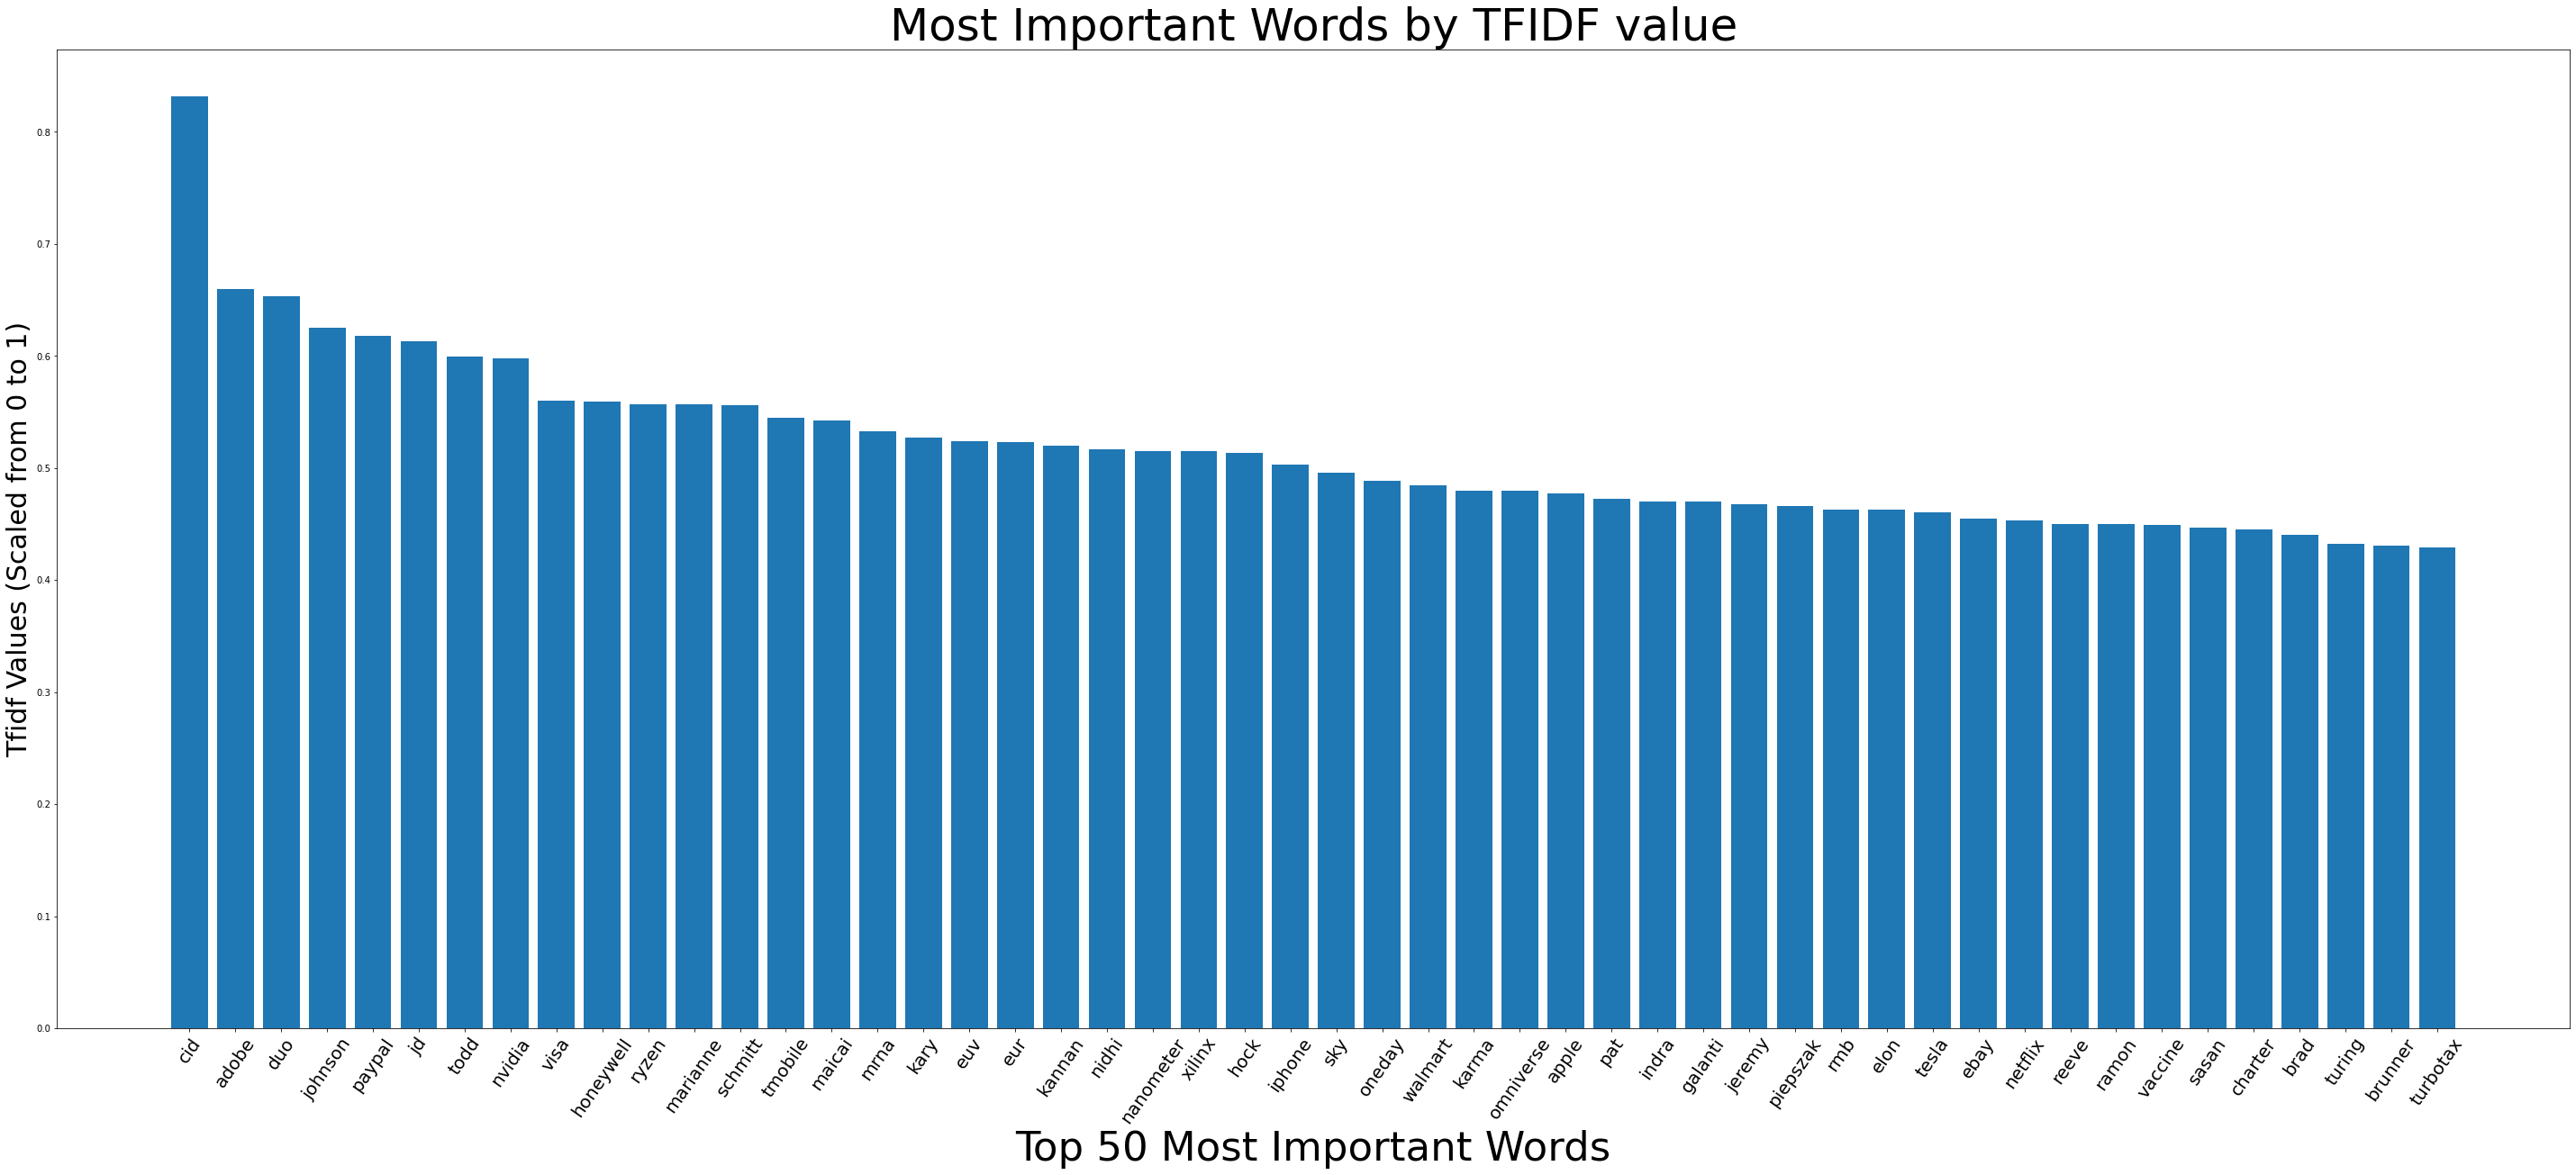

In [95]:
most_important_words_viz(tfidf_df, 50)

In [96]:
# visualize distribution of 0 (decrease in stock price) and 1 (increase in stock price)

def piedist(df, title):
    """ df: dataframe (resampling method)
        title: name of resampling method, for pie chart title """
    target_labels = {0:'Decrease in Stock Price', 1:'Increase in stock price'}
    colors = {0:'paleturquoise', 1:'darkcyan'}
    
    # Find counts for each target value
    df_target_unique = df['target'].value_counts()
    
    # Create labels for pie chart
    labels = []
    palette = []
    for index, row in zip(df_target_unique.index, df_target_unique):
        labels.append(f'{target_labels[index]}: {row}')
        palette.append(colors[index])

    # Create pie plot of target value distribution
    fig, ax = plt.subplots(figsize=(10,10))

    plt.pie(df_target_unique, labels=labels, autopct='%1.1f%%' , colors=palette)
    plt.title(f'Distribution of Target Values {title}', fontsize=15)

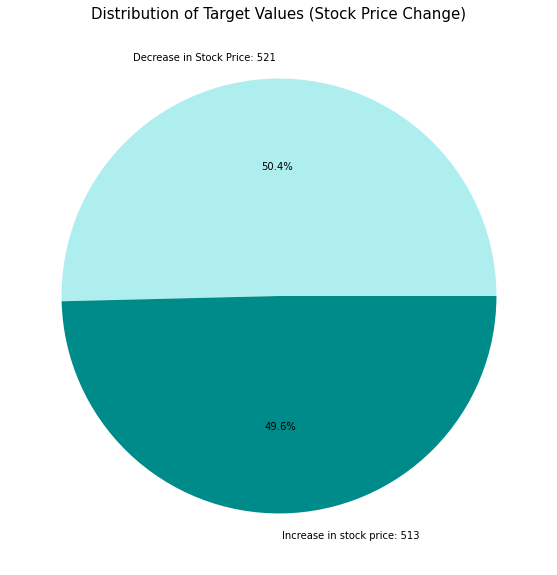

In [97]:
piedist(pca_df, '(Stock Price Change)')

### Functions to Support Visualizations

In [98]:
def query_data_for_single_company(company_name):
    '''Get a list of texts containing all transcripts from a sepcific company'''
    #query mongo db to get transcripts from a specific company
    trancripts = db.transcript.find({"name":company_name})

    text = []
    # Load transcripts and append then to the text list
    for transcript in trancripts:
        text.append(transcript["transcript"])
            
    return text

In [99]:
def tfidf_for_single_company(text):
    ''' Tfidf vectorizer to match words to TFIDF values (min_df=1) '''
    vect = TfidfVectorizer(min_df=1, ngram_range = (1, 1)).fit(text)
    bag_of_words = vect.transform(text)
    feature_names = vect.get_feature_names()

    tfidf_df = pd.DataFrame(bag_of_words.toarray(), columns = feature_names)

    return tfidf_df, bag_of_words

In [100]:
def pca_for_single_company(bag_of_words,n_components, compnay_name):
    ''' PCA to reduce total number of features before feeding into ML model (for one company) '''
    # instantiate the PCA object and request reduced number of components (reduces number of columns/features)
    pca = PCA(n_components=n_components, random_state=3000)

    # standardize the features so they are all on the same scale
    features_standardized = StandardScaler().fit_transform(bag_of_words.toarray())

    # transform the standardized features using the PCA algorithm 
    reduced_data = pca.fit_transform(features_standardized)

    # show transformed results in dataframe
    pca_df = pd.DataFrame(reduced_data)#, columns = components)

    ''' Obtain target values (whether stock price increased, decreased, or stayed the same) 
    from database '''
    price_changes = []
    all_transcripts = db.transcript.find({"name":compnay_name}) ##load transcripts from that specific company
    for transcript in all_transcripts:
        price_changes.append(transcript['price_change'])

    pca_df['target'] = price_changes 

    return pca_df

In [101]:
def visualize_tagerts_for_each_company(company_list):
    '''Generate pie charts with 0's and 1's (targets) for each company'''
    for company in company_list:
        #get bag of words using the functions that are customized for one single company
        text_per_compnay = query_data_for_single_company(company)
        tfidf_df_per_company, bag_of_words_per_company = tfidf_for_single_company(text_per_compnay)
        
        # assign the number of features for each company as the number of components for PCA
        index = tfidf_df_per_company.index
        num_features = len(index)
        pca_df_per_company = pca_for_single_company(bag_of_words_per_company,num_features,company)
        # use our built-in pie chart generating function to generate pie chart for each company
        title = 'for ' + company + ' (Stock Price Change)'
        piedist(pca_df_per_company, title)

/var/folders/f8/d4gwjvws74db26qzz416hhj80000gn/T/ipykernel_15661/3613484892.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(10,10))


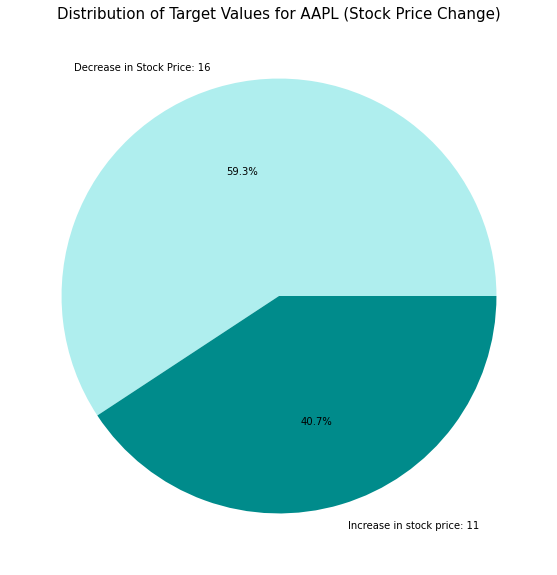

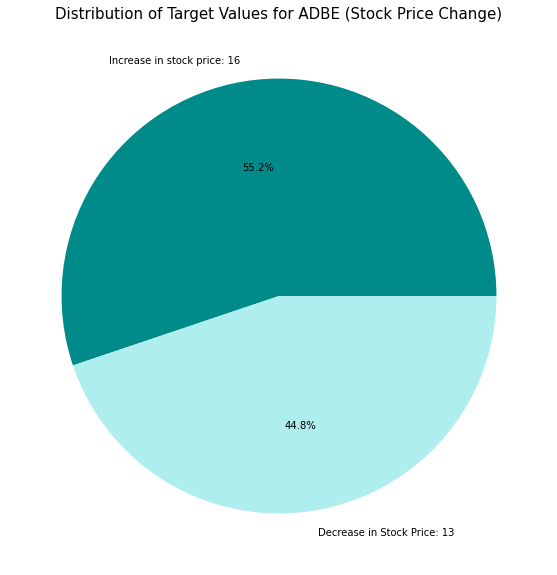

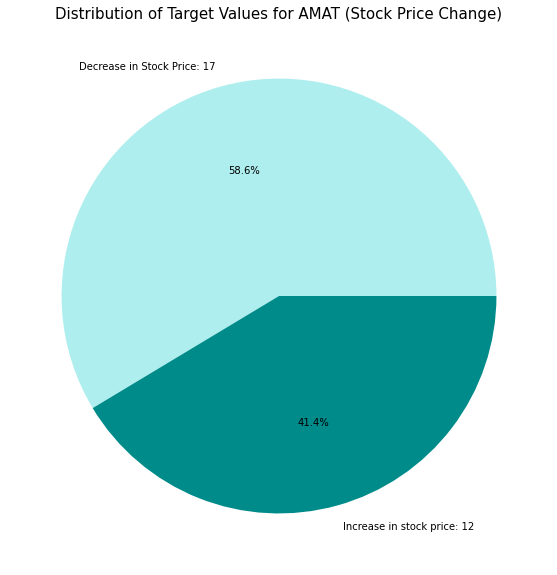

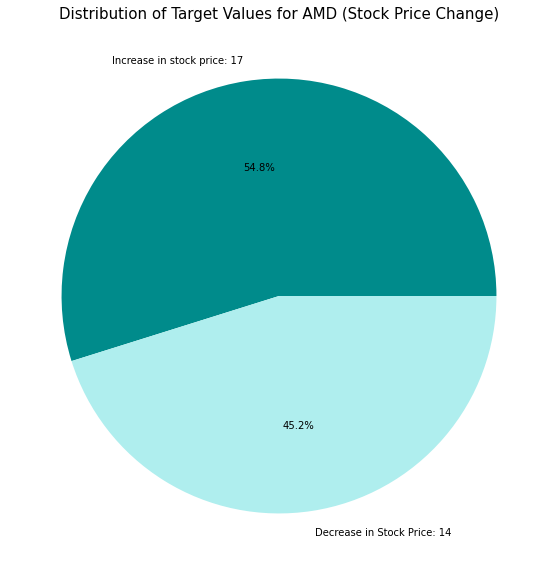

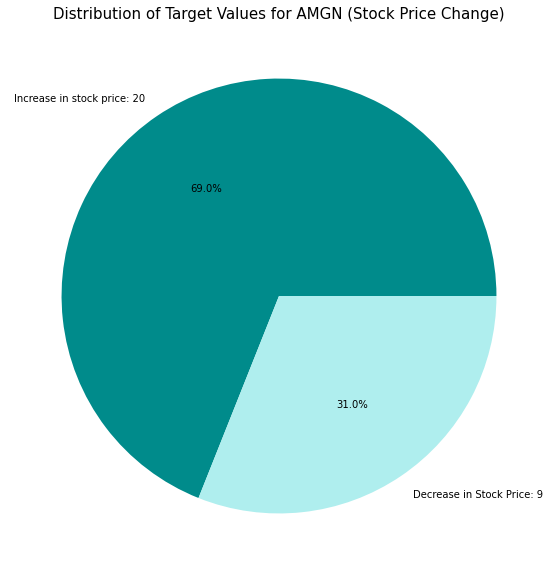

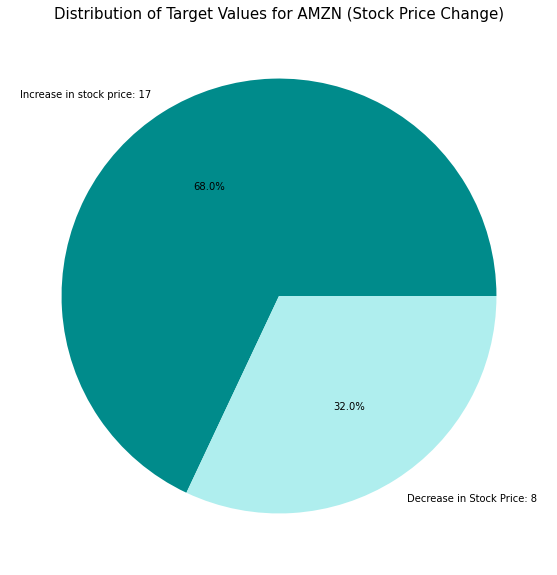

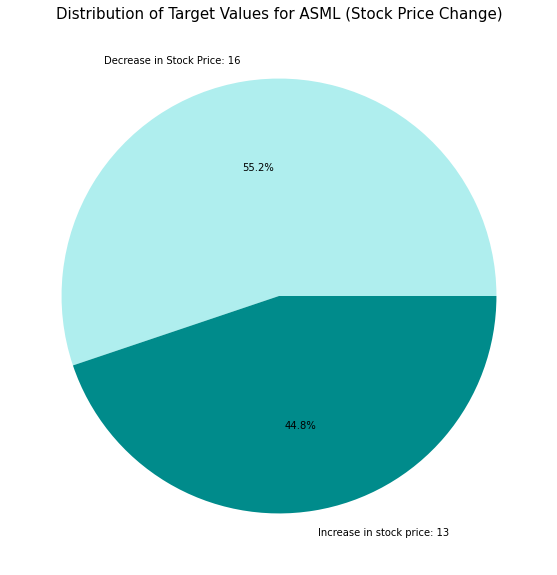

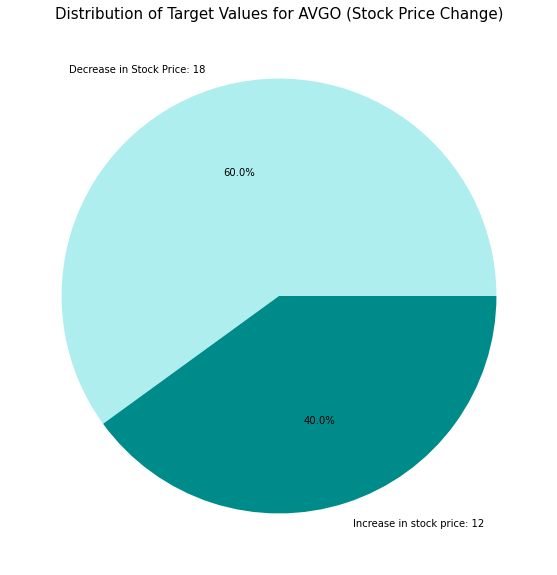

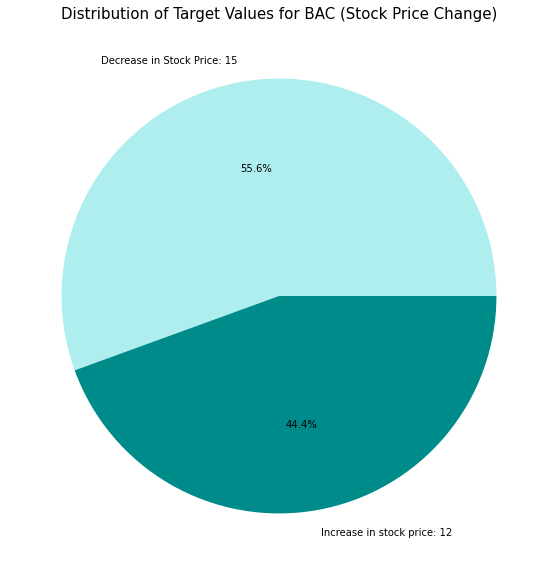

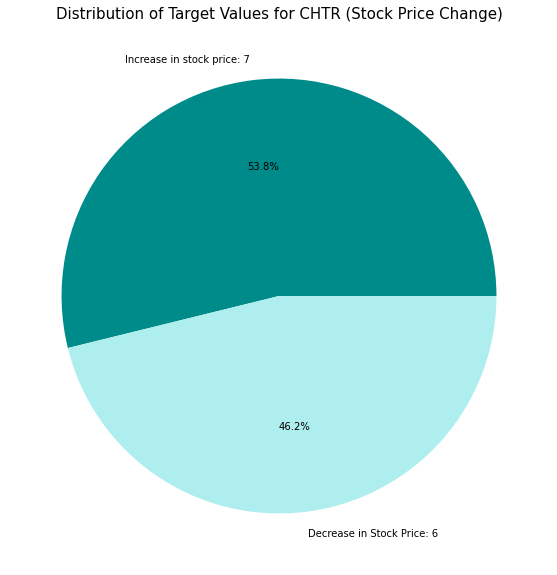

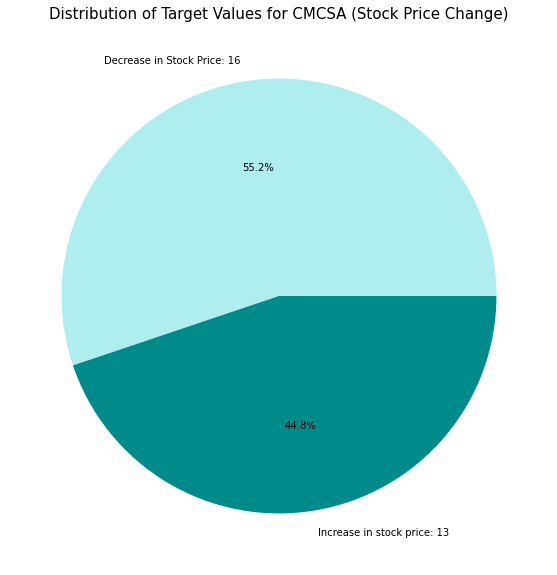

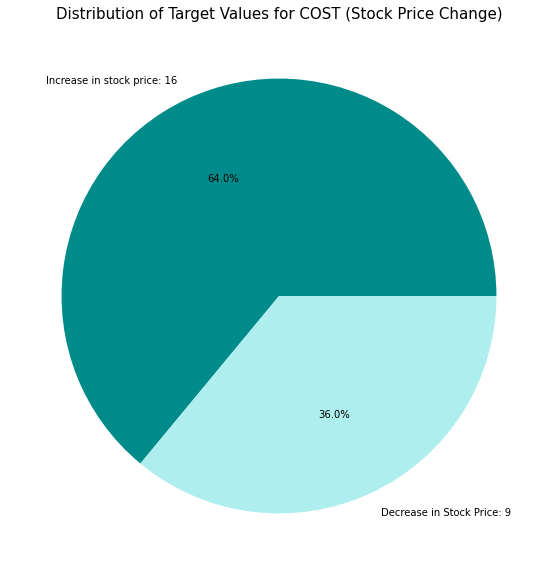

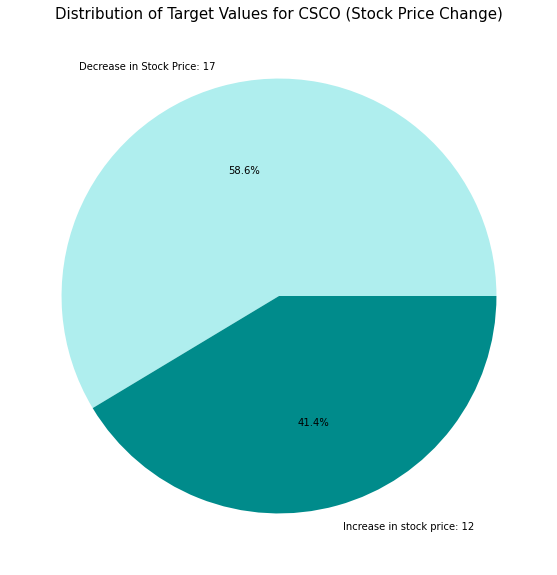

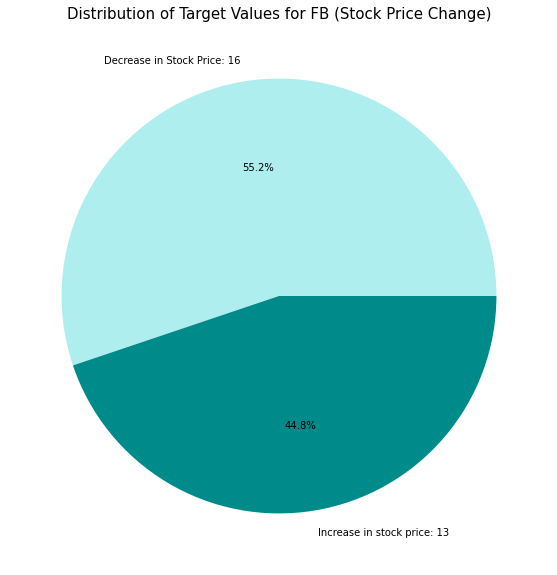

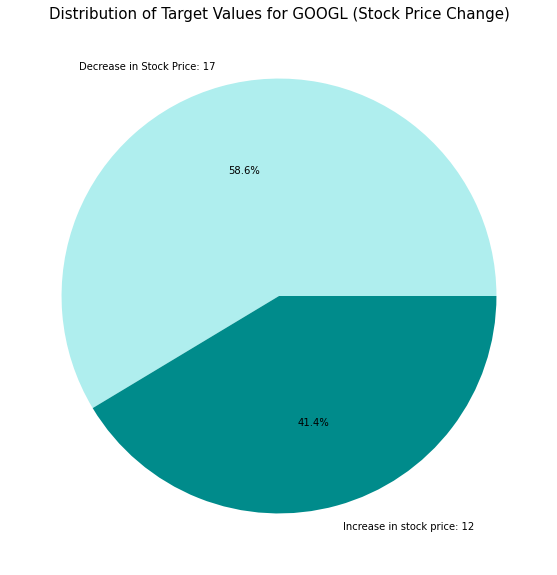

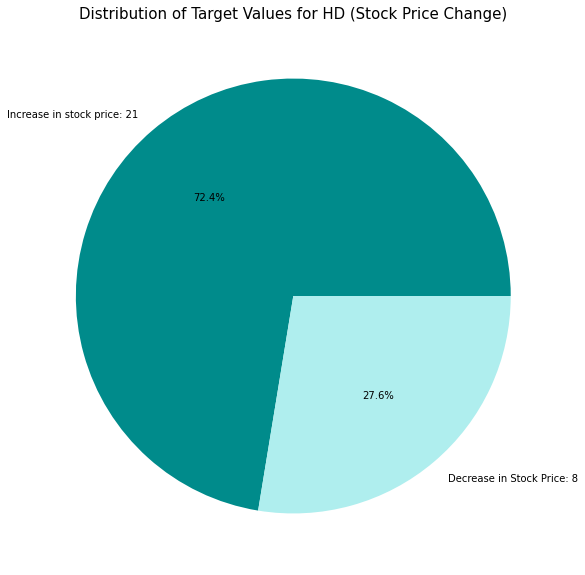

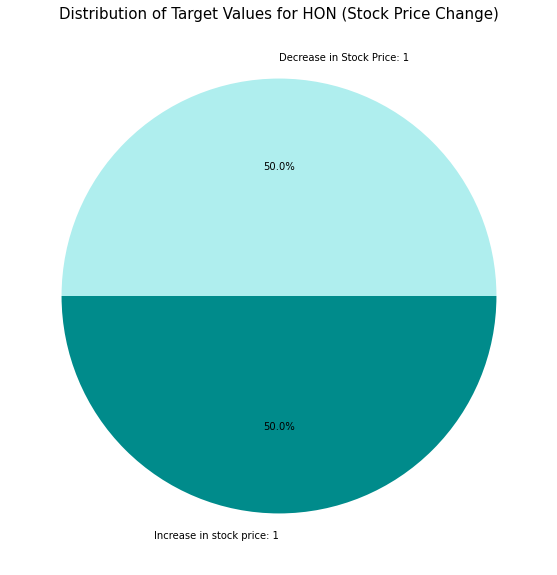

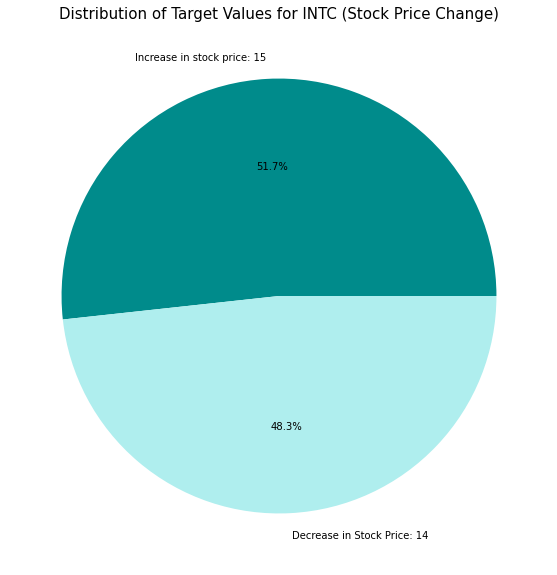

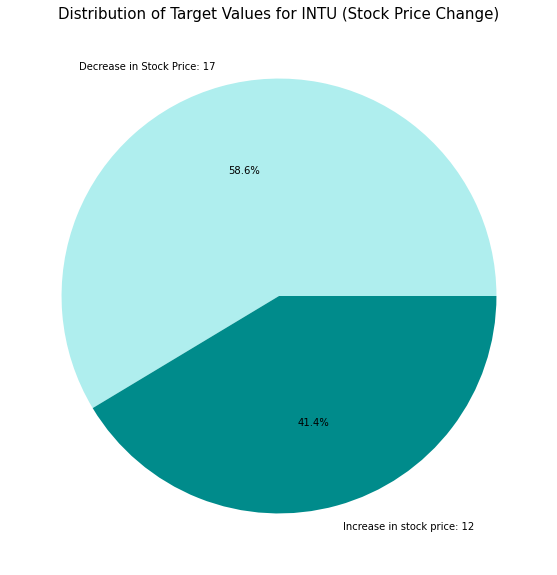

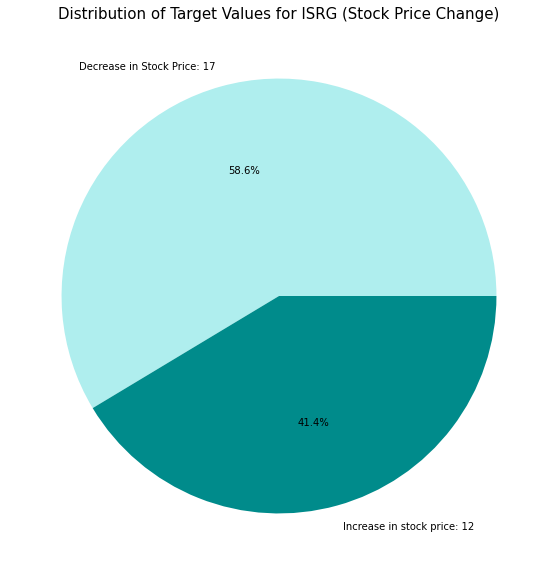

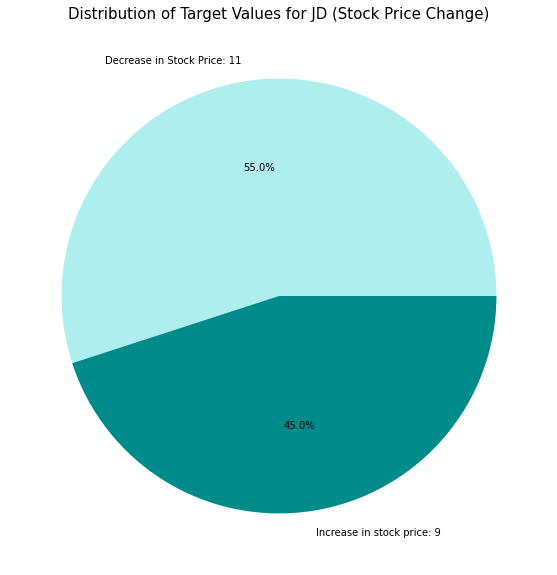

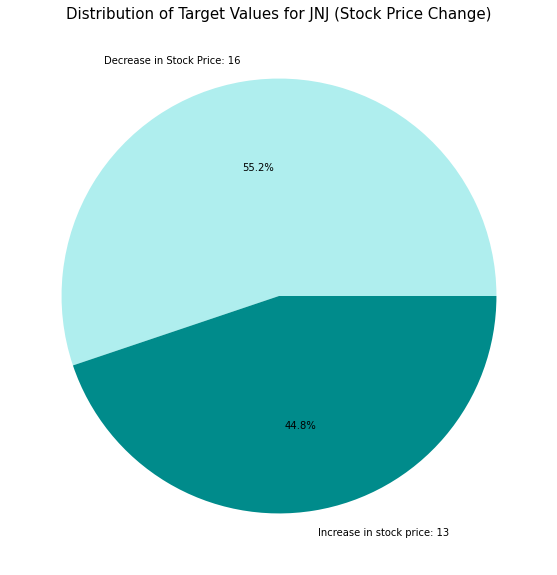

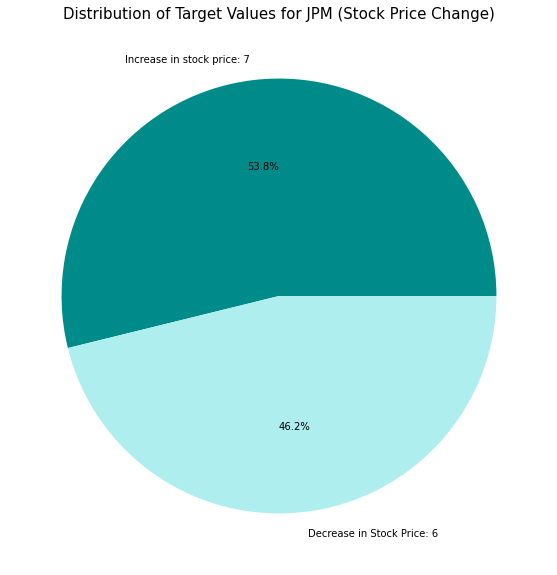

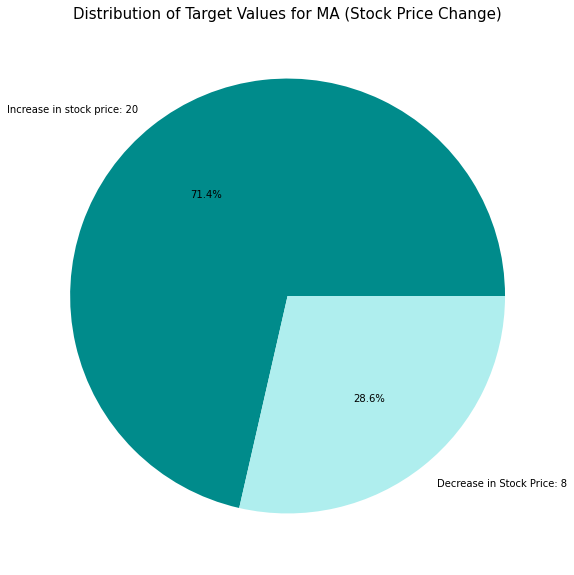

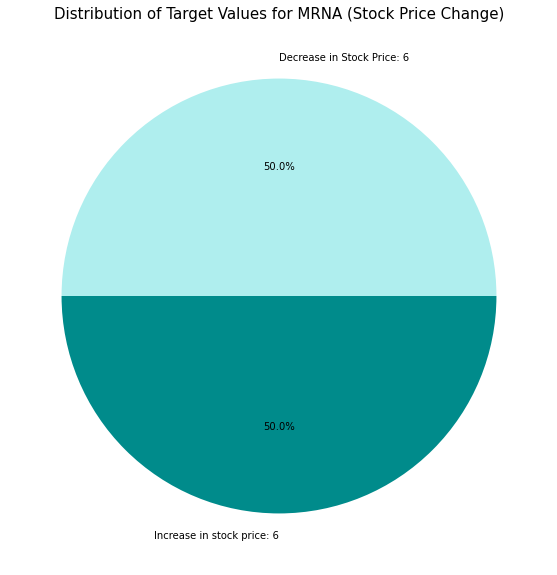

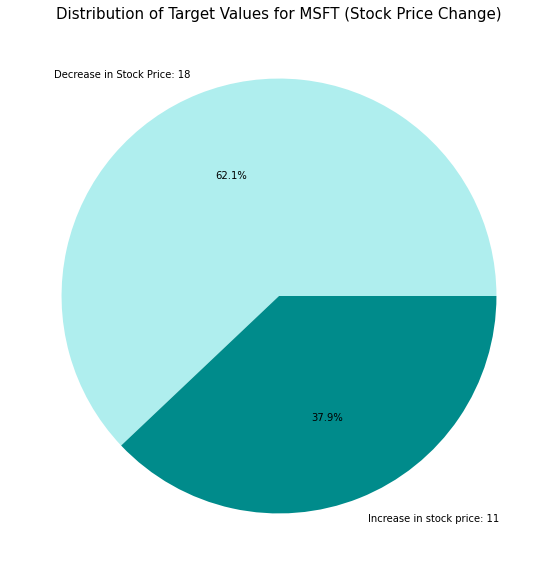

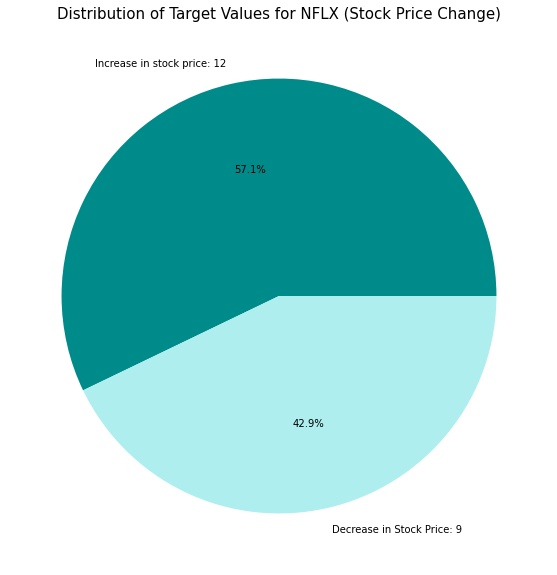

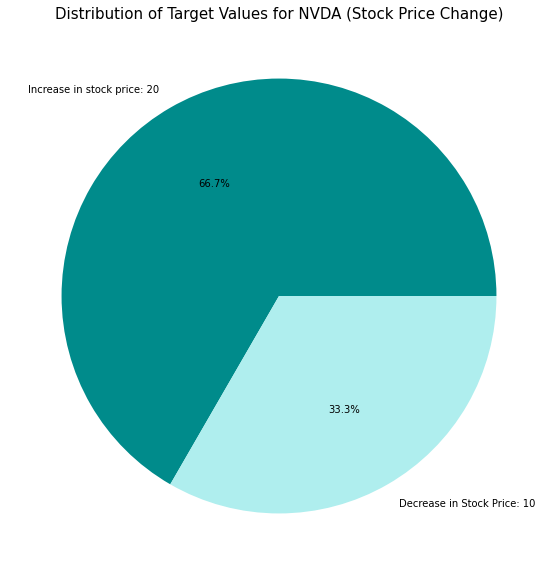

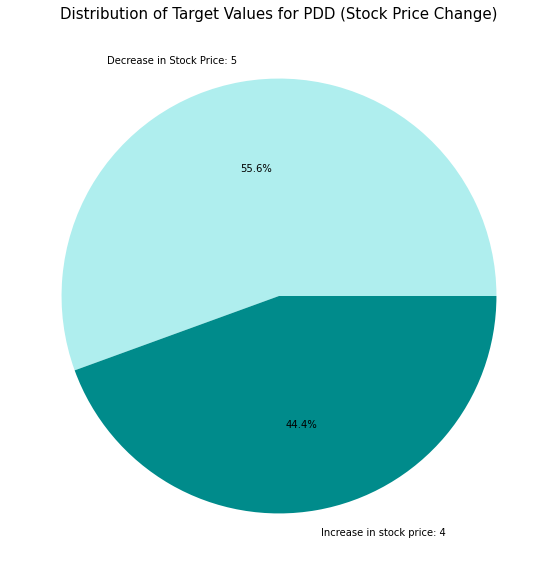

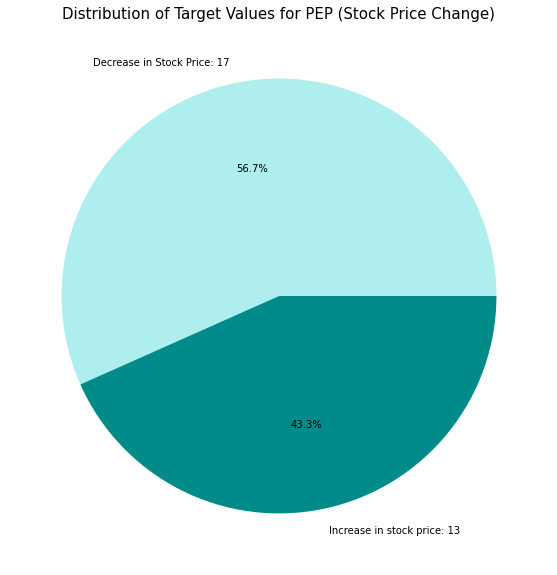

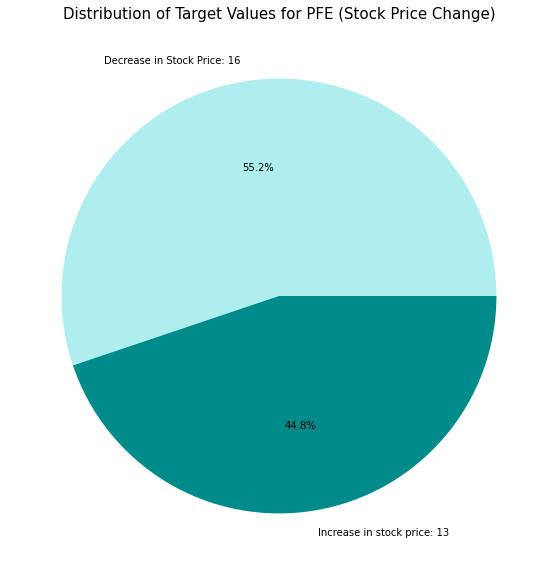

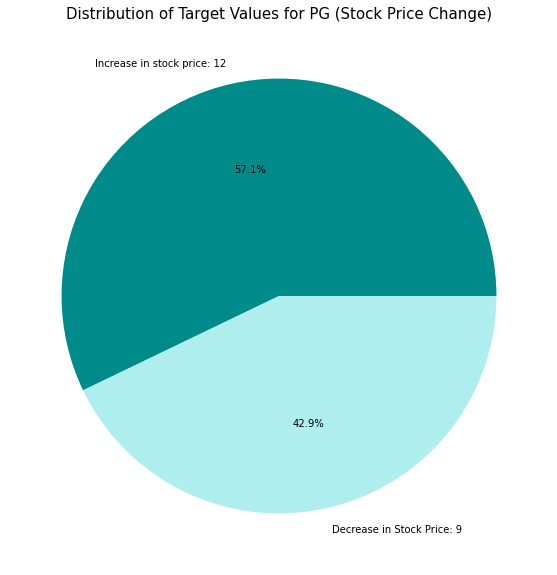

In [102]:
# visualize distribution of 0's and 1's by company

companies = ['AAPL', 'ADBE', 'AMAT', 'AMD', 'AMGN', 'AMZN', 'ASML', 'AVGO', 'BAC', 'CHTR', 
           'CMCSA', 'COST',  'CSCO', 'FB', 'GOOGL', 'HD', 'HON', 'INTC', 'INTU', 'ISRG',
           'JD', 'JNJ', 'JPM', 'MA', 'MRNA', 'MSFT', 'NFLX', 'NVDA', 'PDD', 'PEP', 'PFE', 
           'PG']
#call visuliazation function
visualize_tagerts_for_each_company(companies)

In [104]:
# bar chart showing frequency of transcripts by company ticker

# Query to obtain all company and transcripts
all_companies = db.transcript.find()
company_frequencies = {}

# Create dictionary of companies and their counts
for transcript in all_companies:
    if transcript['name'] not in company_frequencies:
        company_frequencies[transcript['name']] = 1
    else:
        company_frequencies[transcript['name']] += 1
        
import plotly.express as px

# Turn dictionary into dataframe
df = pd.DataFrame(list(company_frequencies.items()), columns = ['Company', 'Frequencies'])

# Generate bar chart showing company frequencies (number of earnings call transcripts per company)
fig = px.bar(df, x='Company', y='Frequencies', title = "Distribution of Companies (by Number of Transcripts)",
             color = 'Company', color_discrete_sequence=px.colors.qualitative.Set3)

fig.show()

In [109]:
# bar chart of accuracy of different models

accuracies= performance.loc['all', 'accuracy'].to_list()
names = performance.columns.values
acc_df = pd.DataFrame(columns=names)
acc_df.loc[len(acc_df)] = accuracies

list_of_models = ['Base: Logistic Regression', 'Base: Support Vector Machine', 'Base: Guassian Naive Bayes', 
                  'Base: Decision Tree', 'GridSearchCV: Logistic Regression', 'GridSearchCV: Support Vector Machine', 
                  'GridSearchCV: Guassian Naive Bayes', 'GridSearchCV: Decision Tree']
import plotly.express as px
fig = px.bar(acc_df, x=list_of_models, y=accuracies, title="Accuracies of Models", color=accuracies,
             labels={'y':'Accuracies', 'x': 'Models'})
fig.show()

Text(0, 0.5, 'Percentage')

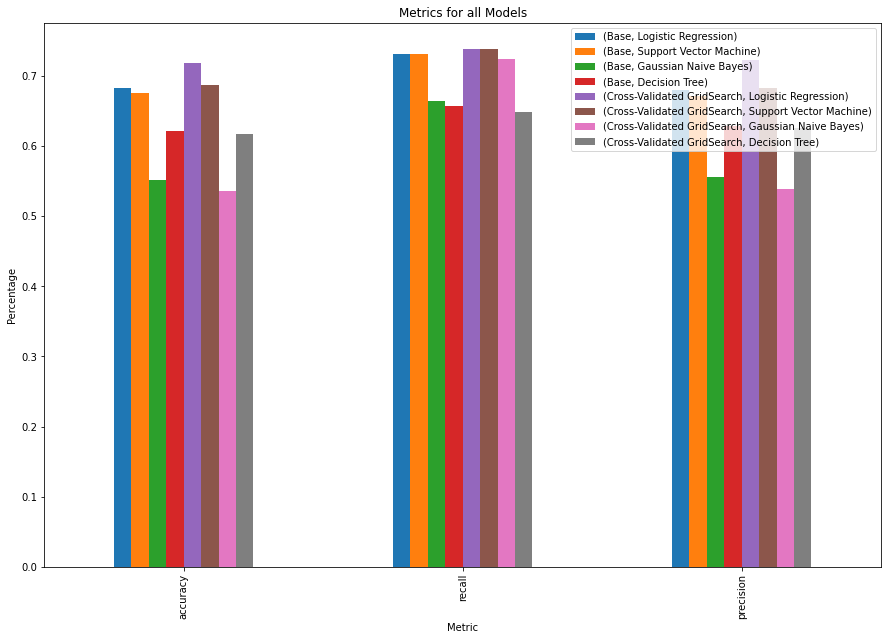

In [110]:
# bar chart of accuracy, precision, and recall of each model

accuracies= performance.loc['all', 'accuracy'].to_list()
# get the different model names
names = performance.columns.values
# create an empty dataframe with the model names as the column names
metric_df = pd.DataFrame(columns=names)
# adds accuracy values to dataframe
metric_df.loc[len(metric_df)] = accuracies
# make recall row into a list
recall = performance.loc['0', 'recall'].to_list()
# adds recall values to dataframe
metric_df.loc[len(metric_df)] = recall
# make precision row into a list 
precision = performance.loc['0', 'precision'].to_list()
# adds precision to dataframe
metric_df.loc[len(metric_df)] = precision
# creates a frame with the name of the different metrics
metric_df.insert(0, 'Metric',['accuracy', 'recall', 'precision'])
# make metric column the index
metric_df.set_index('Metric', drop=True, inplace=True)
# renames columns to include cross validation
metric_df.rename(columns= {'Logistic Regression.1': 'CV Logistic Regression', 'Support Vector Machine.1': 'CV Support Vector Machine', 'Gaussian Naive Bayes.1': 'CV Gaussian Naive Bayes', 'Decision Tree.1': 'CV Decision Tree'})

# create bar chart from dataframe 
fig = metric_df.plot.bar(figsize=(15,10), title= 'Metrics for all Models')
# set label of y axis
fig.set_ylabel('Percentage')

# 9. Demo

In [111]:
# edited database class for demo (doesn't drop existing database)

class DatabaseExample:
    def __init__(self):
        client = MongoClient()
        self.db = client.transcripts

    def store_data(self, tickers_lst):
        for t in tickers_lst:
            store = Transcripts(t)
            transcript = store.create_dct()
            self.db.transcript.insert_many(transcript)
            print(t + " transcripts stored successfully")
        return self.db

In [112]:
# example data ticker
example_ticker = ['SBUX']

# create instance of database class and store transcript data
example_database = DatabaseExample()
example_db = example_database.store_data(example_ticker)

SBUX transcripts stored successfully


In [113]:
# vectorize entire database of transcript text including example transcript
example_data, example_text = query_data()
example_tfidf_df, example_bag_of_words = tfidf(example_text)

aa  aaa  aacr  aaos      aapl  aaron  aarp   ab  abandon  abandoned  \
0     0.0  0.0   0.0   0.0  0.196606    0.0   0.0  0.0      0.0        0.0   
1     0.0  0.0   0.0   0.0  0.179677    0.0   0.0  0.0      0.0        0.0   
2     0.0  0.0   0.0   0.0  0.119407    0.0   0.0  0.0      0.0        0.0   
3     0.0  0.0   0.0   0.0  0.118780    0.0   0.0  0.0      0.0        0.0   
4     0.0  0.0   0.0   0.0  0.200335    0.0   0.0  0.0      0.0        0.0   
...   ...  ...   ...   ...       ...    ...   ...  ...      ...        ...   
1030  0.0  0.0   0.0   0.0  0.000000    0.0   0.0  0.0      0.0        0.0   
1031  0.0  0.0   0.0   0.0  0.000000    0.0   0.0  0.0      0.0        0.0   
1032  0.0  0.0   0.0   0.0  0.000000    0.0   0.0  0.0      0.0        0.0   
1033  0.0  0.0   0.0   0.0  0.000000    0.0   0.0  0.0      0.0        0.0   
1034  0.0  0.0   0.0   0.0  0.000000    0.0   0.0  0.0      0.0        0.0   

      ...  ﬂuctuations     ﬂuid  ﬂuidity  ﬂush  ﬂushed  ﬂux   ﬂy  ﬂyer  ﬂying  \
0     ...     0.000000  0.00000      0.0   0.0     0.0  0.0  0.0   0.0    0.0   
1     ...     0.007141  0.00856      0.0   0.0     0.0  0.0  0.0   0.0    0.0   
2     ...     0.000000  0.00000      0.0   0.0     0.0  0.0  0.0   0.0    0.0   
3     ...     0.000000  0.00000      0.0   0.0     0.0  0.0  0.0   0.0    0.0   
4     ...     0.000000  0.00000      0.0   0.0     0.0  0.0  0.0   0.0    0.0   
...   ...          ...      ...      ...   ...     ...  ...  ...   ...    ...   
1030  ...     0.000000  0.00000      0.0   0.0     0.0  0.0  0.0   0.0    0.0   
1031  ...     0.000000  0.00000      0.0   0.0     0.0  0.0  0.0   0.0    0.0   
1032  ...     0.000000  0.00000      0.0   0.0     0.0  0.0  0.0   0.0    0.0   
1033  ...     0.000000  0.00000      0.0   0.0     0.0  0.0  0.0   0.0    0.0   
1034  ...     0.000000  0.00000      0.0   0.0     0.0  0.0  0.0   0.0    0.0   

       ﬂywheel  
0     0.000000  
1     0.000000  
2     0.000000  
3     0.000000  
4     0.000000  
...        ...  
1030  0.000000  
1031  0.000000  
1032  0.000000  
1033  0.000000  
1034  0.007723  

[1035 rows x 21554 columns]

In [114]:
# reduce dimensionality of text data
example_pca_df = pca(example_bag_of_words, 300)

In [116]:
# separate new transcript from other data
starbucks_pca_df = example_pca_df.tail(1)
starbucks_pca_df

0         1         2         3         4        5         6  \
1034 -0.771419 -9.819002 -1.874061  6.418054 -0.508262  0.49929  0.021466   

             7         8        9  ...        291       292        293  \
1034 -3.360886 -0.204033 -2.47142  ...  19.455431  4.986973  11.974918   

           294       295      296        297       298       299  target  
1034 -7.520693  3.565614  3.71705  11.626714  3.322339 -8.336296       1  

[1 rows x 301 columns]

In [117]:
# training data
example_pca_df = example_pca_df[:-1]
example_pca_df

0          1         2          3          4         5         6  \
0    -8.319392   9.428190 -6.120496   8.124277  -2.968498 -6.764744  0.174161   
1    -7.117551   5.065867 -5.301334   7.138727  -2.970442 -7.816753  1.009325   
2    -5.668393   9.984159  2.728348   2.675779   2.456913 -9.467649  2.331233   
3    -5.491910   8.311980  5.650540  -2.482422   4.218202 -6.110706  1.857201   
4    -7.156263   2.437798 -4.560277   6.324968  -3.942065 -5.201456  0.209543   
...        ...        ...       ...        ...        ...       ...       ...   
1029 -3.512231 -10.512463 -1.011443   6.597947   0.948326 -6.327947  5.449637   
1030 -3.648292   2.312211  8.246876  -4.144554   6.458968 -7.772556  5.931741   
1031 -5.714928  -4.008076  2.427283  -7.656133   5.731708 -5.197072  5.468894   
1032 -5.305994 -12.619277 -3.333101  -0.525985   3.049213 -4.143076  1.969164   
1033 -6.019390  -0.030896  8.923673 -11.895937  10.620701 -8.720114  7.351516   

              7         8          9  ...       291        292       293  \
0     -6.191094  2.434147  -3.315828  ... -2.687905  -2.822925 -1.305218   
1     -6.868339 -0.580917  -4.105281  ...  4.679324 -12.482490 -1.475129   
2     -2.378866 -3.348469   6.818858  ...  1.648430   4.536418  2.774121   
3     -2.272064 -3.915782   7.253417  ... -1.454481   4.721456  2.366781   
4     -5.079882  2.621184  -2.175797  ... -8.853809  -5.490533 -4.489284   
...         ...       ...        ...  ...       ...        ...       ...   
1029 -12.539945 -1.797251  -6.011629  ... -2.209726  -0.933428  0.202496   
1030  -4.170778 -5.399187   5.131383  ... -1.444291  -0.595061  0.952390   
1031  -7.795272 -3.967803  -7.521376  ... -2.845450   2.743770  0.427020   
1032  -9.614063 -1.420104 -10.815502  ...  4.002761   6.050702 -0.782870   
1033  -4.902511 -7.970554   1.301073  ... -2.580266   2.081127  0.524227   

           294        295       296        297       298        299  target  
0    -1.777728  -6.516704 -0.021372  -3.127073 -2.418494  -2.180276       0  
1    -6.492995   3.321287 -4.158851  -2.295338 -0.682229   3.371733       0  
2     0.143395  -0.764473  1.359432  -3.885975 -0.763276   0.570927       1  
3     0.857349   3.646832  0.130193   7.618974  6.490800 -10.116766       1  
4    -2.314958  10.079539  3.197789  12.533167  6.564208 -10.902638       0  
...        ...        ...       ...        ...       ...        ...     ...  
1029 -0.379787   1.478199  1.205632   3.779561  2.485998  -3.051671       0  
1030 -0.825420   0.469796  1.328191   1.454261  0.599269  -1.650015       0  
1031  6.184676   4.649246 -4.236175  -0.807336  7.879408  -2.114943       0  
1032 -2.231660  -4.859643  8.457130  -1.220323 -1.761742   1.316950       1  
1033  7.182803   5.257452 -4.574971  -0.778962  8.182606  -2.946395       0  

[1034 rows x 301 columns]

In [118]:
# train model using Logistic Regression
example_features = example_pca_df.drop("target", axis = 1)
example_target = example_pca_df["target"]
X_train, X_test, y_train, y_test = train_test_split(example_features, example_target, random_state=3000)
example_model = LogisticRegression().fit(X=X_train, y=y_train)

# output performance evaluation scores
accuracy_test = example_model.score(X_test, y_test)
accuracy_train = example_model.score(X_train, y_train)
predicted = example_model.predict(X=X_test)
print("Logistic Regression:")
print("Prediction accuracy on the test data:", f"{accuracy_test:.2%}", "\n")
print("Prediction accuracy on the train data:", f"{accuracy_train:.2%}", "\n")

Logistic Regression:
Prediction accuracy on the test data: 68.73% 

Prediction accuracy on the train data: 95.23% 



/Users/xinyuwu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [129]:
# use trained model to predict on new transcript
prediction = example_model.predict(X=starbucks_pca_df.drop("target", axis=1))[0]
target = int(starbucks_pca_df['target'])
if prediction == target:
    print(f'Model predicted {prediction} and the real value is {target}. The prediction is correct')
    
else:
    print(f'Model predicted {prediction} and the real value is {target}. The prediction is incorrect')

Model predicted 1 and the real value is 1. The prediction is correct


# 10. Pickle Model

In [134]:
import pickle

In [136]:
# train highest performing model
features = pca_df.drop("target", axis = 1)
target = pca_df["target"]
    
final_model = KFold(n_splits = 20, random_state = 3000, shuffle = True)
scores = cross_val_score(estimator = LogisticRegression(), X=features, y=target, cv=final_model)
print("Logistic Regression K-Fold Cross Validation: \n\t" + f"mean accuracy={scores.mean():.2%} " + f"standard deviation={scores.std():.2%}" + "\n")

/Users/xinyuwu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/xinyuwu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/xinyuwu

Logistic Regression K-Fold Cross Validation: 
	mean accuracy=77.76% standard deviation=6.14%



/Users/xinyuwu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/xinyuwu/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/xinyuwu

In [138]:
# pickle model
pickle.dump(final_model, open('final_model.pkl','wb'))